# Analysis of configurational frustration
## Motivation
Our aim is to determine whether there is a statistically significant difference or enrichment of frustrated residues or residue pairs in **cryptic binding sites (CBSs)**, with the ultimate goal of incorporating this insight into future CBS prediction methods.  
We focus on comparing configurational frustration between **CBSs** and **rigid binding sites (BSs)**. In addition, we investigate whether changes in residue distances between the apo (ligand-free) and holo (ligand-bound) forms - i.e. how residue pairs move - are reflected in frustration values.  
Our hypothesis is that we expect the frustration to be enriched in CBSs, particularly in regions where conformational changes occur (i.e. residues exhibit movement).

## Background
### Data
#### Cryptic binding site dataset
We curated novel CBS dataset, CryptoBench ([paper](academic.oup.com/bioinformatics/article/41/1/btae745/7927823)), where the cryptic binding site is defined as:  
*"... a region in a protein that can bind a ligand and undergoes a significant structural change between its holo (ligand-bound) and apo (unbound) forms. A significant change is defined as a difference of at least 2 Å RMSD between the binding residues in the apo and holo forms."*.  
In total, we collected **1,107 structures** with CBSs using an automated pipeline, of which **885** are part of the training set.

#### Rigid binding site dataset
To explore the role of conformational movement in binding sites, we also curated a dataset of **rigid binding sites** using a similar pipeline. A rigid BS is defined as a site showing **no more than 0.5 Å RMSD** between binding residues in the apo and holo forms. This resulted in **642 structures**, with **511** assigned to the training set.

### Frustration computation
Frustration was calculated using the [frustratometeR R package](https://github.com/proteinphysiologylab/frustratometeR). Although both **mutational** and **configurational** frustration modes were computed, this analysis focuses exclusively on the **configurational mode**, using only **pairwise frustration values** (from `{protein_id}.pdb_configurational` files). The analysis was performed on the training subsets of both datasets.


## Overview of methods
We conducted several experiments to examine how configurational frustration behaves under different conditions. The analyses are presented in the following order:
1. **Overall frequency**:  
How frequent are high, neutral, and minimal frustration categories in CBSs, rigid BSs, and non-binding residues?
2. **Per-pocket analysis**:  
What is the average number of minimally, neutrally, and highly frustrated pairs per pocket?
   - Includes both absolute counts and values normalized by pocket size
   - Also examines how many pockets contain at least one frustrated pair of each type
3. **Conservation**:  
Is frustration reduced in conserved residues?
4. **Movement-linked frustration**:  
Is frustration increased in residues or residue pairs that exhibit structural movement between apo and holo states?

## Conclusion
1. We did not observe any significant differences in the distribution of minimal, neutral, or high frustration between **CBSs vs. rigid BSs**, or **binding vs. non-binding** residue pairs.
2. While the average number of frustrated pairs (minimal, neutral, high) differs between the CBS and rigid BS datasets, these differences largely disappear after **normalizing by pocket size**. Notably, a substantial number of pockets do not contain any **highly frustrated** residue pairs (both rigid and cryptic).
3. Frustration is **reduced** in **conserved residue pairs** compared to **unconserved** pairs.
4. Frustration levels show **slight variation** in residue pairs that undergo conformational movement between the apo and holo states.


First define some methods for loading the frustration ...

In [2]:
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
import os, csv
import scipy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import sys
sys.path.append('../../utils/')
import dataset_utils

FOLDER_PATH = '/home/vit/Projects/flexibility-analysis/'

def get_conservation_path(dataset):
    return f'{FOLDER_PATH}/data/features/conservation/{dataset}'

def get_frustration_path(dataset, mode, id=None):
    if id:
        return f'{FOLDER_PATH}/data/features/frustration/{dataset}/{mode}/{id}_{id[4]}.done'
    return f'{FOLDER_PATH}/data/features/frustration/{dataset}/{mode}'

def get_dataset_path(dataset):
    return f'{FOLDER_PATH}/datasets/{dataset}'

def get_paired_frustration_stats(dataset, mode, id, binding_annotation):
    frustration_filepath = get_frustration_path(dataset, mode, id)

    both_binding_frustration = []
    one_binding_frustration = []
    none_binding_frustration = []
    
    filename = f'{id}_{id[4]}.pdb_{mode}'
    with open(f'{frustration_filepath}/FrustrationData/{filename}') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            residue1 = int(row[0]) - 1
            residue2 = int(row[1]) - 1
            frustration = row[13]
            if residue1 in binding_annotation and residue2 in binding_annotation:
                both_binding_frustration.append(frustration)
            elif residue1 in binding_annotation or residue2 in binding_annotation:
                one_binding_frustration.append(frustration)
            else:
                none_binding_frustration.append(frustration)

    return both_binding_frustration, one_binding_frustration, none_binding_frustration

def get_paired_frustration_stats_with_conservation(dataset, mode, id):
    frustration_filepath = get_frustration_path(dataset, mode, id)
    conservation_path = get_conservation_path(dataset)
    
    if not os.path.exists(f'{conservation_path}/{id}.npy'):
        # print(f'Conservation file not found for {id}')
        return [], [], []

    conservation = (np.load(f'{conservation_path}/{id}.npy') > 0).astype(int)
    res_id_to_conservation = {}
    both_binding_frustration = []
    one_binding_frustration = []
    none_binding_frustration = []
    
    
    filename = f'{id}_{id[4]}.pdb_{mode}'
    with open(f'{frustration_filepath}/FrustrationData/{filename}_5adens') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        
        prev_res_id = float('inf')
        conservation_iterator = 0
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            residue1 = int(row[0]) - 1
            if prev_res_id == residue1:
                continue

            prev_res_id = residue1
            res_id_to_conservation[residue1] = conservation[conservation_iterator]
            conservation_iterator += 1

    if conservation_iterator != len(conservation):
        return [], [], []

    with open(f'{frustration_filepath}/FrustrationData/{filename}') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            residue1 = int(row[0]) - 1
            residue2 = int(row[1]) - 1
            frustration = row[13]
            if res_id_to_conservation[residue1] and res_id_to_conservation[residue2]:
                both_binding_frustration.append(frustration)
            elif res_id_to_conservation[residue1] or res_id_to_conservation[residue2]:
                one_binding_frustration.append(frustration)
            else:
                none_binding_frustration.append(frustration)

    return both_binding_frustration, one_binding_frustration, none_binding_frustration

def load_paired_dataset(dataset, mode, with_respect_to='binding'):
    if with_respect_to != 'binding' and with_respect_to != 'conservation':
        raise ValueError('Unknown with_respect_to value')
    
    frustration_directory = get_frustration_path(dataset, mode)
    both_binding_values = []
    one_binding_values = []
    none_binding_values = []
    if with_respect_to == 'binding':
        binding_residues = dataset_utils.get_annotations(get_dataset_path(dataset))

    for file in os.listdir(frustration_directory):
        file_path = os.path.join(frustration_directory, file)
        id = file.split('_')[0]
        
        # if exception occured when calculating the frustration
        if not os.path.isdir(os.path.join(file_path, 'FrustrationData')):
            continue
        # if the indices (i.e. fluctuation length from which the indices are derived) don't match the number of amino acids in PDB provided by frustrameter
        if not check_consistency(dataset, mode, id):
            continue
        
        # print(f'Processing {id} ...')
        if with_respect_to == 'binding':
            both_binding_value, one_binding_value, none_binding_value = get_paired_frustration_stats(dataset, mode, id, binding_residues[id])
        elif with_respect_to == 'conservation':
            both_binding_value, one_binding_value, none_binding_value = get_paired_frustration_stats_with_conservation(dataset, mode, id)
        
        both_binding_values.extend(both_binding_value)
        one_binding_values.extend(one_binding_value)
        none_binding_values.extend(none_binding_value)
    
    return both_binding_values, one_binding_values, none_binding_values

def check_consistency(dataset, mode, id):
    fluctuation_path = f'/home/vit/Projects/flexibility-analysis/data/features/fluctuation/{dataset}/fluctuation'
    frustration_path = get_frustration_path(dataset, mode, id)
    pdb_filename = f'{id}_{id[4]}.pdb'
    pdb_file = pdb.PDBFile.read(f'{frustration_path}/FrustrationData/{pdb_filename}')

    # load file to biotite object
    whole_structure = pdb.get_structure(pdb_file, model=1, include_bonds=True)
    protein = whole_structure[struc.filter_amino_acids(whole_structure)]

    # some errors with MSE residue
    c_alphas = protein[(protein.atom_name == "CA") 
                       & (protein.element == "C") 
                       & (protein.chain_id == id[4]) # the PDB had to be tweaked before because the chain id can have only one character
                       & (
                             (protein.res_name == 'ALA')
                           | (protein.res_name == 'ARG')
                           | (protein.res_name == 'ASN')
                           | (protein.res_name == 'ASP')
                           | (protein.res_name == 'CYS')
                           | (protein.res_name == 'GLN')
                           | (protein.res_name == 'GLU')
                           | (protein.res_name == 'GLY')
                           | (protein.res_name == 'HIS')
                           | (protein.res_name == 'ILE')
                           | (protein.res_name == 'LEU')
                           | (protein.res_name == 'LYS')
                           | (protein.res_name == 'MET')
                           | (protein.res_name == 'PHE')
                           | (protein.res_name == 'PRO')
                           | (protein.res_name == 'SER')
                           | (protein.res_name == 'THR')
                           | (protein.res_name == 'TRP')
                           | (protein.res_name == 'TYR')
                           | (protein.res_name == 'VAL'))]

    # better check with the fluctuation data too:
    fluctuation_data_len = len(np.load(f'{fluctuation_path}/{id}.npy'))
    if len(c_alphas) != fluctuation_data_len:
        return False
    return True

def print_paired_frustration_stats(values, title=None):
    values = np.array(values)
    overall_len = len(values)
    high_frustration = values[values == 'highly']
    neutral_frustration = values[values == 'neutral']
    minimal_frustration = values[values == 'minimally']
    assert overall_len == len(high_frustration) + len(neutral_frustration) + len(minimal_frustration), f'{overall_len} != {len(high_frustration)} + {len(neutral_frustration)} + {len(minimal_frustration)}'
    if title:
        print(title)
    print(f'{len(high_frustration)} ({len(high_frustration) / (overall_len) * 100:.2f}%) - high frustration')
    print(f'{len(neutral_frustration)} ({len(neutral_frustration) / overall_len * 100:.2f}%) - neutral frustration')
    print(f'{len(minimal_frustration)} ({len(minimal_frustration) / overall_len * 100:.2f}%) - minimal frustration')
    print()


# 1. What is the overall frequency of high/neutral/minimal frustration?
We begin by comparing the frequency of each frustration category across the **cryptic** and **rigid** datasets.

In [3]:
both_binding_values_cryptic, one_binding_values_cryptic, none_binding_values_cryptic = load_paired_dataset('cryptobench-dataset', 'configurational')
print('CRYPTIC DATASET:')
print()
for values, title in zip((both_binding_values_cryptic, one_binding_values_cryptic, none_binding_values_cryptic), ('both binding', 'one binding','non-binding')):
    print_paired_frustration_stats(values, title)

CRYPTIC DATASET:

both binding
1624 (7.75%) - high frustration
13890 (66.27%) - neutral frustration
5447 (25.99%) - minimal frustration

one binding
8128 (6.40%) - high frustration
82304 (64.77%) - neutral frustration
36640 (28.83%) - minimal frustration

non-binding
100317 (8.16%) - high frustration
769164 (62.53%) - neutral frustration
360596 (29.31%) - minimal frustration



### How to read the stats

*CRYPTIC DATASET:*  
  
*both binding*  
*1624 (7.75%) - high frustration*  
*...*  

This means that, within the CBS dataset, among all frustrated residue pairs where **both residues are part of a cryptic binding site, 1,624 pairs** are classified as **highly frustrated**. This corresponds to **7.75%** of all frustrated pairs in which both residues are binding.

In [4]:
both_binding_values_rigid, one_binding_values_rigid, none_binding_values_rigid = load_paired_dataset('rigid-dataset', 'configurational')
print('RIGID DATASET:')
print()
for values, title in zip((both_binding_values_rigid, one_binding_values_rigid, none_binding_values_rigid), ('both binding', 'one binding','non-binding')):
    print_paired_frustration_stats(values, title)

RIGID DATASET:

both binding
442 (7.29%) - high frustration
4127 (68.10%) - neutral frustration
1491 (24.60%) - minimal frustration

one binding
4207 (6.44%) - high frustration
44337 (67.89%) - neutral frustration
16760 (25.66%) - minimal frustration

non-binding
92270 (8.20%) - high frustration
725686 (64.46%) - neutral frustration
307924 (27.35%) - minimal frustration



### How to read the stats

*RIGID DATASET:*  
  
*both binding*  
*442 (7.29%) - high frustration*  
*...*  

This means that, within the rigid dataset, among all frustrated residue pairs where **both residues are part of a rigid binding site, 442 pairs** are classified as **highly frustrated**. This corresponds to **7.29%** of all frustrated pairs in which both residues are binding.

### Plot it
Visualize the frequencies using a bar chart. The number above each bar represents the sample count for that category.

In [ ]:
import math  

def print_paired_frequence(data, labels, title):
    plt.figure(figsize=(12, 6))
    x = np.arange(0, len(data))

    for i, values in enumerate(data):
        values = np.array(values)

        overall_count = len(values)
        high_frustration = values[values == 'highly']
        neutral_frustration = values[values == 'neutral']
        minimal_frustration = values[values == 'minimally']

        minimal_frustration_frequence = len(minimal_frustration) / overall_count
        neutral_frustration_frequence = len(neutral_frustration) / overall_count
        high_frustration_frequence = len(high_frustration) / overall_count

        assert math.isclose(minimal_frustration_frequence + neutral_frustration_frequence + high_frustration_frequence, 1)

        bar = plt.bar([i-0.2, i, i+0.2], [high_frustration_frequence, neutral_frustration_frequence, minimal_frustration_frequence], width=0.1)

        # Add text to the top of each bar
        plt.text(i-0.2, high_frustration_frequence + 0.01, f'{len(high_frustration)}', ha='center', va='bottom', fontsize=8)
        plt.text(i, neutral_frustration_frequence + 0.01, f'{len(neutral_frustration)}', ha='center', va='bottom', fontsize=8)
        plt.text(i+0.2, minimal_frustration_frequence + 0.01, f'{len(minimal_frustration)}', ha='center', va='bottom', fontsize=8)

        # fill with color:
        for i, patch in enumerate(bar.patches):
            patch.set_facecolor(colors[i])

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4)]

    plt.legend(custom_lines, legend_labels)
    plt.xticks(x, labels)
    plt.ylabel('Frequence')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def print_rearranged_paired_frequence(data, labels, title):
    plt.figure(figsize=(12, 6))
    x = np.arange(0, len(data))

    for i_pair_type, values_pair_type in enumerate(data): # both_binding, one_binding, none_binding
        for ii_binding_type, vvalues_binding_type in enumerate(values_pair_type): # rigid, cryptic
            values = np.array(vvalues_binding_type)

            overall_count = len(values)
            high_frustration = values[values == 'highly']
            neutral_frustration = values[values == 'neutral']
            minimal_frustration = values[values == 'minimally']

            minimal_frustration_frequence = len(minimal_frustration) / overall_count
            neutral_frustration_frequence = len(neutral_frustration) / overall_count
            high_frustration_frequence = len(high_frustration) / overall_count

            assert math.isclose(minimal_frustration_frequence + neutral_frustration_frequence + high_frustration_frequence, 1)
            
            i = i_pair_type - (0.05 * (len(values_pair_type) / 2)) + (ii_binding_type * 0.1)

            step = 0.1 * len(values_pair_type)

            bar = plt.bar([i-step, i, i+step], [high_frustration_frequence, neutral_frustration_frequence, minimal_frustration_frequence], width=0.05)

            # Add text to the top of each bar
            plt.text(i-step, high_frustration_frequence + 0.01, f'{len(high_frustration)}', ha='center', va='bottom', fontsize=8)
            plt.text(i, neutral_frustration_frequence + 0.01, f'{len(neutral_frustration)}', ha='center', va='bottom', fontsize=8)
            plt.text(i+step, minimal_frustration_frequence + 0.01, f'{len(minimal_frustration)}', ha='center', va='bottom', fontsize=8)

            # fill with color:
            for i, patch in enumerate(bar.patches):
                patch.set_facecolor(colors[ii_binding_type][i])

    custom_lines = [Line2D([0], [0], color=c, lw=4) for cc in colors for c in cc]

    plt.legend(custom_lines, [i for ii in legend_labels for i in ii], bbox_to_anchor=(0.8,1))
    plt.xticks(x, labels)
    plt.ylabel('Frequence')
    plt.title(title)
    plt.tight_layout()
    plt.show()



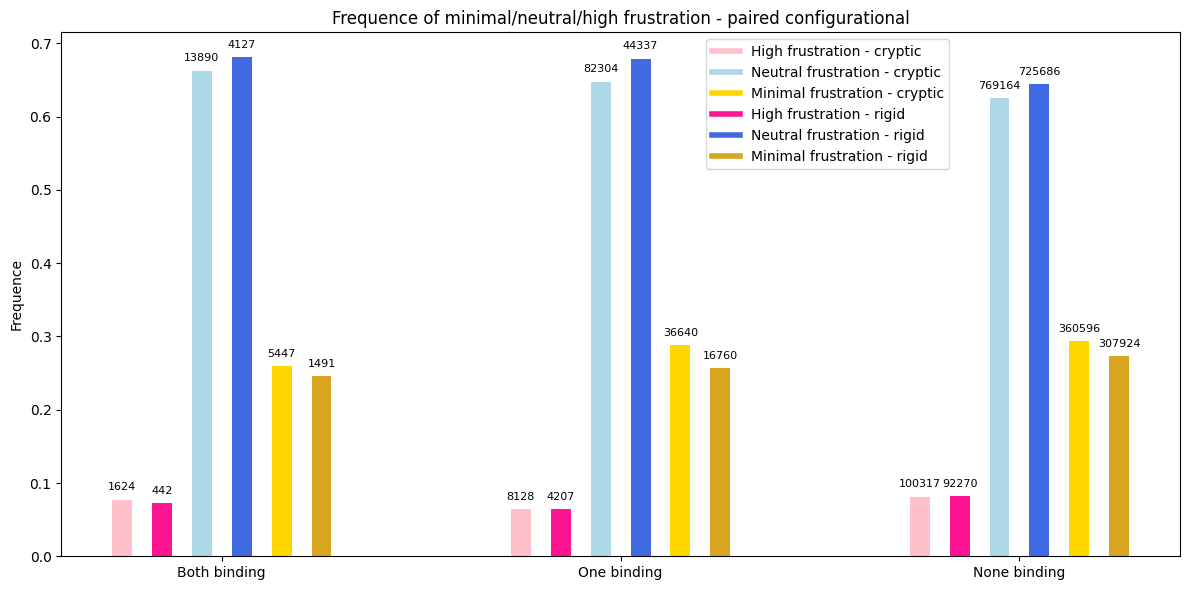

In [25]:
colors = [['pink', 'lightblue', "gold"], ['deeppink', 'royalblue', 'goldenrod']]
legend_labels = [['High frustration - cryptic', 'Neutral frustration - cryptic', 'Minimal frustration - cryptic'],
                ['High frustration - rigid', 'Neutral frustration - rigid', 'Minimal frustration - rigid']]

xlabels = ['Both binding', 'One binding', 'None binding']
print_rearranged_paired_frequence([[both_binding_values_cryptic, both_binding_values_rigid], [one_binding_values_cryptic,
             one_binding_values_rigid], [none_binding_values_cryptic, none_binding_values_rigid]], labels=xlabels,
             title='Frequence of minimal/neutral/high frustration - paired configurational')

The same plot values are shown, just rearranged.  
**Note**: The frequencies within each bar triplet sum to one.

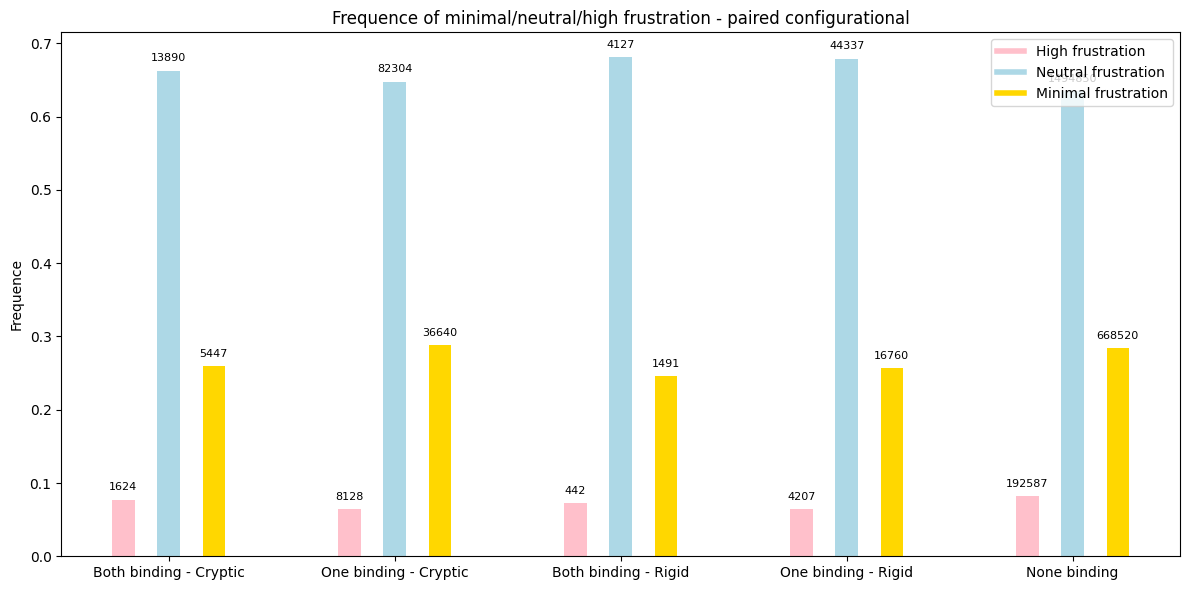

In [28]:
none_binding_values = none_binding_values_cryptic + none_binding_values_rigid
colors = ['pink', 'lightblue', "gold"]
legend_labels = ['High frustration', 'Neutral frustration', 'Minimal frustration']
labels = ['Both binding - Cryptic', 'One binding - Cryptic', 'Both binding - Rigid', 'One binding - Rigid', 'None binding']
print_paired_frequence([both_binding_values_cryptic, one_binding_values_cryptic,
             both_binding_values_rigid, one_binding_values_rigid, none_binding_values], labels=labels,
             title='Frequence of minimal/neutral/high frustration - paired configurational')

### Conclusion
We observe no significant differences in the frequency of frustration categories between **rigid** and **cryptic** binding residue pairs, nor between **binding** and **non-binding** residue pairs in general.

# 2. Per-pocket analysis
Shifting from a per-residue to a **per-pocket** perspective, we now explore the extent of frustration **within each pocket**.

In [3]:
def tweaked_jackard(pocket1, pocket2):
    '''Returns true if the pockets are similar enough. The pockets are similar if they meet at least one of the following criteria:
    1. The Jaccard index is greater than 0.5
    2. One of the pockets substantially overlaps with the intersection of the pockets - it could happen that one pocket is [1,2,3] and other is [1,2,3,4,5,6,7]. 
        In that case Jaccard index would be lower than 0.5, but the pockets are similar enough'''
    pocket1 = set(pocket1)
    pocket2 = set(pocket2)

    intersection = pocket1.intersection(pocket2)
    union = pocket1.union(pocket2)
    
    # For debugging purposes: (if you would like to further tweak the metric)
    # if not (len(intersection) / len(union) > 0.5 or \
    #         len(intersection) > 0.5 * len(pocket1) or \
    #         len(intersection) > 0.5 * len(pocket2)):
    #     print(len(intersection) / len(union), len(intersection) / len(pocket1), len(intersection) / len(pocket2))
    
    return len(intersection) / len(union) > 0.5 or \
           len(intersection) / len(pocket1) > 0.5 or \
           len(intersection) / len(pocket2) > 0.5

def load_pockets(dataset, dataset_name):
    pockets = {}

    for apo_pdb_id, holo_structures in dataset.items():
        path = get_frustration_path(dataset_name, 'configurational')

        if f'{apo_pdb_id}{holo_structures[0]["apo_chain"]}_{holo_structures[0]["apo_chain"]}.done' not in os.listdir(path):
            continue

        for holo_structure in holo_structures:
            current_pocket = set([int(i.split('_')[1]) for i in holo_structure['apo_pocket_selection']])
            id = f'{apo_pdb_id}{holo_structure["apo_chain"]}'
            if id not in pockets:
                pockets[id] = []
                pockets[id].append(current_pocket)

            # check if I should merge this pocket with another pocket or if it is unique
            else:
                unique = True
                for i, other_pocket in enumerate(pockets[id]):
                    if tweaked_jackard(current_pocket, other_pocket):
                        # merge the pockets
                        unique = False
                        pockets[id][i] = current_pocket.union(other_pocket)
                        break
                    
                if unique:
                    pockets[id].append(current_pocket)
    return pockets


In [4]:
def get_pocket_frustration(dataset, mode, id, pocket_annotation):
    '''Find frustration values, where both residues from the pair are a part of the pocket'''
    '''Returns three lists - high frustration, neutral frustration and low frustration'''
    frustration_filepath = get_frustration_path(dataset, mode, id)

    high_frustration = []
    neutral_frustration = []
    low_frustration = []
    
    if not os.path.isdir(os.path.join(frustration_filepath, 'FrustrationData')):
        return [], [], []
    # if the indices (i.e. fluctuation length from which the indices are derived) don't match the number of amino acids in PDB provided by frustrameter
    if not check_consistency(dataset, mode, id):
        return [], [], []

    filename = f'{id}_{id[4]}.pdb_{mode}'
    with open(f'{frustration_filepath}/FrustrationData/{filename}') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        next(csv_reader, None)
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            residue1 = int(row[0]) - 1
            residue2 = int(row[1]) - 1
            frustration = row[13]
            if residue1 in pocket_annotation and residue2 in pocket_annotation:
                if frustration == 'minimally':
                    low_frustration.append((residue1, residue2))
                elif frustration == 'neutral':
                    neutral_frustration.append((residue1, residue2))
                elif frustration == 'highly':
                    high_frustration.append((residue1, residue2))
                else:
                    raise ValueError(f'Unknown frustration value {frustration}')

    return high_frustration, neutral_frustration, low_frustration

def extract_frustration_for_each_pocket(dataset, mode, pockets):
    '''Returns a dictionary, where the keys are the pocket ids and the values are lists of tuples (pocket residues, high frustration, neutral frustration, low frustration)'''
    pockets_with_frustration = {}
    for apo_id, pockets_per_protein in pockets.items():
        if apo_id not in pockets_with_frustration:
            pockets_with_frustration[apo_id] = []
        # load the frustration data
        for pocket in pockets_per_protein:
            high_frustration, neutral_frustration, low_frustration = get_pocket_frustration(dataset, mode, apo_id, pocket)
            
            # if error occured when calculating the frustration
            if high_frustration == [] and neutral_frustration == [] and low_frustration == []:
                continue

            # add the pocket to the dictionary
            pockets_with_frustration[apo_id].append((pocket, high_frustration, neutral_frustration, low_frustration))
    return pockets_with_frustration

In [5]:
import statistics

DATASET = 'cryptobench-dataset'
cryptobench_dataset = dataset_utils.load_train_set(get_dataset_path(DATASET))
cryptobench_pockets = load_pockets(cryptobench_dataset, DATASET)
print(f'Dataset: {DATASET}')
print(f'Number of structures: {len(cryptobench_pockets)}')
print(f'Number of pockets: {sum([len(i) for i in cryptobench_pockets.values()])}')
print(f'Avg. pocket size: {statistics.mean(sum([[len(pocket) for pocket in per_protein_pockets] for per_protein_pockets in cryptobench_pockets.values()], []))}')
print(f"Format of the pockets for each structure is list of sets - let's see the pockets for '2e1cA':\n{cryptobench_pockets['2e1cA']}")
cryptobench_pockets_with_frustration = extract_frustration_for_each_pocket(DATASET, 'configurational', cryptobench_pockets)

print('\n\n')
DATASET = 'rigid-dataset'
rigid_dataset = dataset_utils.load_train_set(get_dataset_path(DATASET))
rigid_pockets = load_pockets(rigid_dataset, DATASET)
print(f'Dataset: {DATASET}')
print(f'Number of structures: {len(rigid_pockets)}')
print(f'Number of pockets: {sum([len(i) for i in rigid_pockets.values()])}')
print(f'Avg. pocket size: {statistics.mean(sum([[len(pocket) for pocket in per_protein_pockets] for per_protein_pockets in rigid_pockets.values()], []))}')
print(f"Format of the pockets for each structure is list of sets - let's see the pockets for '5z0uA':\n{rigid_pockets['5z0uA']}")
rigid_pockets_with_frustration = extract_frustration_for_each_pocket(DATASET, 'configurational', rigid_pockets)


Dataset: cryptobench-dataset
Number of structures: 700
Number of pockets: 797
Avg. pocket size: 15.841907151819322
Format of the pockets for each structure is list of sets - let's see the pockets for '2e1cA':
[{160, 161, 130, 80, 81, 85, 86, 87, 88, 158, 159}, {138, 141, 142, 153, 154, 155}]



Dataset: rigid-dataset
Number of structures: 468
Number of pockets: 595
Avg. pocket size: 9.030252100840336
Format of the pockets for each structure is list of sets - let's see the pockets for '5z0uA':
[{400, 448, 418, 451, 452, 455}, {65, 41, 75, 43, 77}]


## Number of frustrated pairs per pocket
We calculate the **average number of residue pairs per pocket** for each frustration category: **minimal, neutral,** and **high**.

In [7]:
for dataset_name, pockets_with_frustration in zip(('cryptobench-dataset', 'rigid-dataset'), (cryptobench_pockets_with_frustration, rigid_pockets_with_frustration)):
    high_pairs_count = []
    neutral_pairs_count = []
    minimal_pairs_count = []
    for pocket_id, pocket_data in pockets_with_frustration.items():
        for pocket, high_frustration, neutral_frustration, low_frustration in pocket_data:
            high_pairs_count.append(len(high_frustration))
            neutral_pairs_count.append(len(neutral_frustration))
            minimal_pairs_count.append(len(low_frustration))
    print('\n')
    print(f'Dataset: {dataset_name}')
    print(f"Mean number of highy frustrated pairs: {statistics.mean(high_pairs_count):.2f}")
    print(f"Mean number of neutraly frustrated pairs: {statistics.mean(neutral_pairs_count):.2f}")
    print(f"Mean number of lowy frustrated pairs: {statistics.mean(minimal_pairs_count):.2f}")



Dataset: cryptobench-dataset
Mean number of highy frustrated pairs: 2.04
Mean number of neutraly frustrated pairs: 17.37
Mean number of lowy frustrated pairs: 6.75


Dataset: rigid-dataset
Mean number of highy frustrated pairs: 0.73
Mean number of neutraly frustrated pairs: 7.33
Mean number of lowy frustrated pairs: 2.61


These statistics might be skewed due to differences in the **average number of residues per pocket** across datasets. To account for this, we normalize the values by the **total number of possible residue pairs** within each pocket.

## Number of frustration pairs per pocket, normalized by number of all possible pairs in a pocket
The **average number of residues per pocket** differs between the **rigid** (~9 residues) and **cryptic** (~15 residues) datasets. For each frustration category (**minimal, neutral, high**), we will calculate:
$$ratio = \frac{\text{Number of detected pairs in pocket}}{\text{Number of all possible pairs in pocket}}
$$


In [8]:
for dataset_name, pockets_with_frustration in zip(('cryptobench-dataset', 'rigid-dataset'), (cryptobench_pockets_with_frustration, rigid_pockets_with_frustration)):
    high_ratios = []
    neutral_ratios = []
    low_ratios = []
    for pocket_id, pocket_data in pockets_with_frustration.items():
        for pocket, high_frustration, neutral_frustration, low_frustration in pocket_data:
            number_of_pairs = len(pocket) * (len(pocket) - 1) / 2
            high_ratios.append(len(high_frustration) / number_of_pairs)
            neutral_ratios.append(len(neutral_frustration) / number_of_pairs)
            low_ratios.append(len(low_frustration) / number_of_pairs)
    print('\n')
    print(f'Dataset: {dataset_name}')
    print(f"Median high frustration ratio: {statistics.mean(high_ratios):.2f}")
    print(f"Median neutral frustration ratio: {statistics.mean(neutral_ratios):.2f}")
    print(f"Median minimal frustration ratio: {statistics.mean(low_ratios):.2f}")



Dataset: cryptobench-dataset
Median high frustration ratio: 0.02
Median neutral frustration ratio: 0.13
Median minimal frustration ratio: 0.05


Dataset: rigid-dataset
Median high frustration ratio: 0.03
Median neutral frustration ratio: 0.18
Median minimal frustration ratio: 0.06


### Conclusion
The ratio of highly and minimally frustrated pairs per pocket is similar across both datasets. However, in the rigid dataset, there is a higher occurrence of neutral frustration pairs.

## How many pockets have no high/neutral/low frustration pair?

In [9]:
for dataset_name, pockets_with_frustration in zip(('cryptobench-dataset', 'rigid-dataset'), (cryptobench_pockets_with_frustration, rigid_pockets_with_frustration)):
    high_pairs_count = 0
    neutral_pairs_count = 0
    minimal_pairs_count = 0
    pocket_count = 0
    for pocket_id, pocket_data in pockets_with_frustration.items():
        for pocket, high_frustration, neutral_frustration, low_frustration in pocket_data:
            pocket_count += 1
            if len(high_frustration) > 0:
                high_pairs_count += 1
            if len(neutral_frustration) > 0:
                neutral_pairs_count += 1
            if len(low_frustration) > 0:
                minimal_pairs_count += 1
    print('\n')
    print(f'Dataset: {dataset_name}')
    print(f"Number of pockets with at least one high frustration pair: {high_pairs_count} / {pocket_count} ({high_pairs_count / pocket_count * 100:.2f}%)")
    print(f"Number of pockets with at least one neutral frustration pair: {neutral_pairs_count} / {pocket_count} ({neutral_pairs_count / pocket_count * 100:.2f}%)")
    print(f"Number of pockets with at least one minimal frustration pair: {minimal_pairs_count} / {pocket_count} ({minimal_pairs_count / pocket_count * 100:.2f}%)")



Dataset: cryptobench-dataset
Number of pockets with at least one high frustration pair: 509 / 751 (67.78%)
Number of pockets with at least one neutral frustration pair: 736 / 751 (98.00%)
Number of pockets with at least one minimal frustration pair: 658 / 751 (87.62%)


Dataset: rigid-dataset
Number of pockets with at least one high frustration pair: 215 / 532 (40.41%)
Number of pockets with at least one neutral frustration pair: 510 / 532 (95.86%)
Number of pockets with at least one minimal frustration pair: 385 / 532 (72.37%)


### Conclusion
A significant number of pockets do not contain any highly frustrated pairs.  


The difference in percentages between the two datasets could be due to the inherent differences in pocket characteristics between the **rigid** and **cryptic** datasets, or from the fact that pockets in the **rigid** dataset are, on average, smaller - potentially leading to more pockets that lack any highly, neutrally, or minimally frustrated pairs. Given that the previous graph shows a similar distribution of frustration levels across both datasets, the **latter** explanation appears more likely.

# 3. How about conservation?
How is **frustration** reflected in **conserved residues**? In this analysis, we do not consider the binding vs. non-binding criterion.

In [52]:
DATASET = 'rigid-dataset'
both_conserved_values_rigid, one_conserved_values_rigid, none_conserved_values_rigid = load_paired_dataset(DATASET, 'configurational', with_respect_to='conservation')
print(f'Dataset: {DATASET}\n')
for values, title in zip((both_conserved_values_rigid, one_conserved_values_rigid, none_conserved_values_rigid), ('Both residues are conserved', 'One of the residues is conserved','No residue is conserved')):
    print_paired_frustration_stats(values, title)

DATASET = 'cryptobench-dataset'
print(f'\n\nDataset: {DATASET}\n')
both_conserved_values_cryptic, one_conserved_values_cryptic, none_conserved_values_cryptic = load_paired_dataset(DATASET, 'configurational', with_respect_to='conservation')
for values, title in zip((both_conserved_values_cryptic, one_conserved_values_cryptic, none_conserved_values_cryptic), ('Both residues are conserved', 'One of the residues is conserved','No residue is conserved')):
    print_paired_frustration_stats(values, title)


Dataset: rigid-dataset

Both residues are conserved
11086 (4.81%) - high frustration
134362 (58.28%) - neutral frustration
85106 (36.91%) - minimal frustration

One of the residues is conserved
25642 (6.34%) - high frustration
266586 (65.92%) - neutral frustration
112208 (27.74%) - minimal frustration

No residue is conserved
57181 (10.90%) - high frustration
349523 (66.63%) - neutral frustration
117860 (22.47%) - minimal frustration

Both residues are conserved
12266 (4.10%) - high frustration
167370 (55.97%) - neutral frustration
119396 (39.93%) - minimal frustration

One of the residues is conserved
28232 (5.84%) - high frustration
311097 (64.30%) - neutral frustration
144458 (29.86%) - minimal frustration

No residue is conserved
68551 (11.74%) - high frustration
379730 (65.06%) - neutral frustration
135419 (23.20%) - minimal frustration



### How to read the stats

*...*  
*Both residues are conserved*  
*11086 (4.81%) - high frustration*  
*...*  

This means that among all frustrated residue pairs where **both residues were conserved, 11,086 pairs** are classified as **highly frustrated**. This corresponds to **4.81%** of all frustrated pairs in which both residues are conserved.

### Conclusion
The statistics appear consistent across both **rigid** and **cryptic** datasets: **high frustration** is enriched in pairs **where neither residue is conserved**, while **minimal frustration** is enriched in pairs where **both residues are conserved**.

### Plot it
Let's combine both datasets, as they yield identical results, and plot the frequencies on a bar chart. The number above each bar represents the sample count for that category.

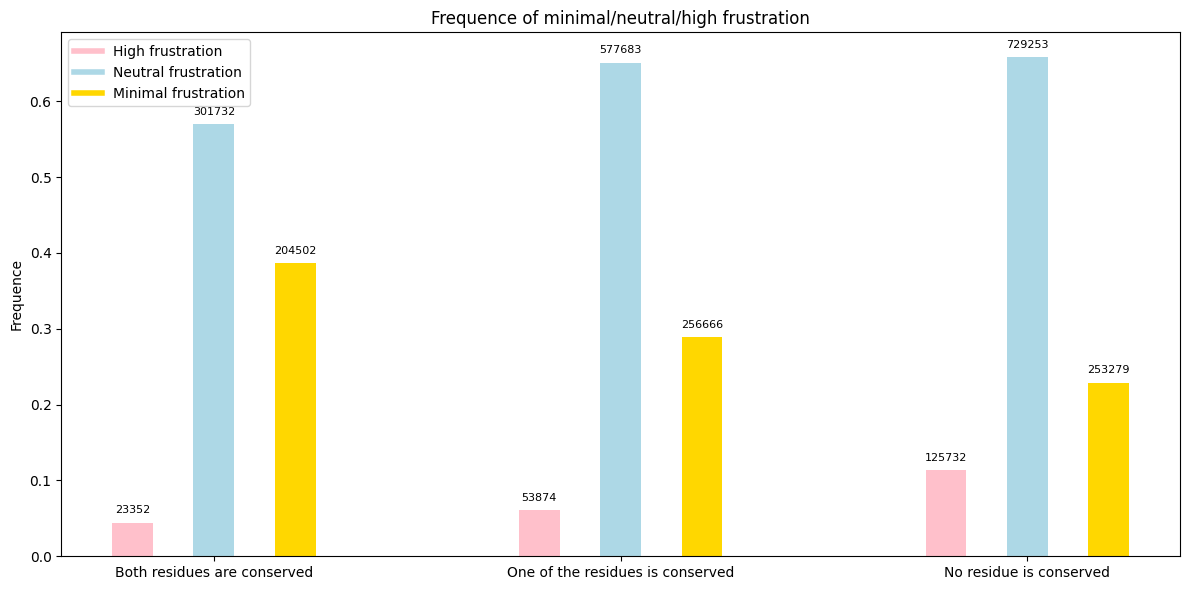

In [40]:
both_conserved_values = both_conserved_values_cryptic + both_conserved_values_rigid
one_conserved_values = one_conserved_values_cryptic + one_conserved_values_rigid
none_conserved_values = none_conserved_values_rigid + none_conserved_values_cryptic

labels = ['Both residues are conserved', 'One of the residues is conserved','No residue is conserved']
print_paired_frequence([both_conserved_values, one_conserved_values, none_conserved_values], labels=labels,
             title='Frequence of minimal/neutral/high frustration')


# 4. Apo-holo distance
Next, we consider the movement of residues, specifically how the distance between residues changes between the **apo** and **holo** states. We'll categorize the residues into bins based on their movement:
- Residues that moved less than 1Å
- Residues that moved between 1–2Å
- Residues that moved between 2–3Å
- And so on.

We'll analyze the frequency of frustration for each bin and plot the results. The number above each bar represents the sample count for that category.

In [53]:
DISTANCE_CLIP_THRESHOLD = 10

def get_locations_path(dataset):
    return f'{FOLDER_PATH}/data/features/residue-locations/{dataset}'

def clip_distances(distances):
    rounded_distances = np.rint(distances)
    rounded_distances = np.clip(rounded_distances, 0, DISTANCE_CLIP_THRESHOLD)
    return rounded_distances

def get_paired_frustration_and_distance(dataset, id, mode='configurational'):
    frustration_filepath = get_frustration_path(dataset, mode, id)
    locations_path = get_locations_path(dataset)

    if not os.path.exists(f'{locations_path}/{id}.npy'):
        return [], []

    locations = np.load(f'{locations_path}/{id}.npy')
    res_id_to_location = {}

    filename = f'{id}_{id[4]}.pdb_{mode}'
    with open(f'{frustration_filepath}/FrustrationData/{filename}_5adens') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        
        prev_res_id = float('inf')
        location_iterator = 0
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            residue = int(row[0]) - 1
            if prev_res_id == residue:
                continue

            prev_res_id = residue
            res_id_to_location[residue] = locations[location_iterator]
            location_iterator += 1

    if location_iterator != len(locations):
        return [], []

    frustrations, distances = [], []
    with open(f'{frustration_filepath}/FrustrationData/{filename}') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=' ')
        
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            if row[0] == 'NA' or row[2] == 'NA':
                continue
            residue1 = int(row[0]) - 1
            residue2 = int(row[1]) - 1
            frustration = row[13]

            # compute distance
            distances.append(abs(np.linalg.norm(res_id_to_location[residue1][0] - res_id_to_location[residue2][0]) \
                             - np.linalg.norm(res_id_to_location[residue1][1] - res_id_to_location[residue2][1])))
            frustrations.append(frustration)

    return frustrations, distances

def load_paired_dataset_with_distance(dataset, mode):
    frustration_directory = get_frustration_path(dataset, mode)
    frustration = []
    distances = []
    for file in os.listdir(frustration_directory):
        file_path = os.path.join(frustration_directory, file)
        id = file.split('_')[0]
        # if exception occured when calculating the frustration
        if not os.path.isdir(os.path.join(file_path, 'FrustrationData')):
            continue
        # if the indices (i.e. fluctuation length from which the indices are derived) don't match the number of amino acids in PDB provided by frustrameter
        if not check_consistency(dataset, mode, id):
            continue

        this_frustration, this_distances = get_paired_frustration_and_distance(dataset, id)
        if len(this_frustration) == 0:
            continue
        frustration.extend(this_frustration)
        distances.extend(this_distances)

    return np.array(frustration), np.array(distances)

def barplot_paired_frustration_frequence(frustration, distances, xlim=(0, DISTANCE_CLIP_THRESHOLD), title='', labels=['', '', ''], xlabel='apo-holo distance'):
    plt.figure(figsize=(12, 6))
    colors = ['pink', 'lightblue', 'gold']

    minimal_frustration_distance = distances[frustration == 'minimally']
    neutral_frustration_distance = distances[frustration == 'neutral']
    high_frustration_distance = distances[frustration == 'highly']

    x = np.array(list(range(xlim[0], xlim[1])))

    for i in x:
        indices1 = np.where(minimal_frustration_distance == i)[0]
        indices2 = np.where(neutral_frustration_distance == i)[0]
        indices3 = np.where(high_frustration_distance == i)[0]

        overall_count = len(indices1) + len(indices2) + len(indices3)
        
        frequence1 = len(indices1) / overall_count
        frequence2 = len(indices2) / overall_count
        frequence3 = len(indices3) / overall_count

        import math  
        assert math.isclose(frequence1 + frequence2 + frequence3, 1)

        bar = plt.bar([i-0.2, i, i+0.2], [frequence3, frequence2, frequence1], width=0.1)
        
        # Add text to the top of each bar
        plt.text(i-0.2, frequence3 + 0.01, f'{len(indices3)}', ha='center', va='bottom', fontsize=8)
        plt.text(i, frequence2 + 0.01, f'{len(indices2)}', ha='center', va='bottom', fontsize=8)
        plt.text(i+0.2, frequence1 + 0.01, f'{len(indices1)}', ha='center', va='bottom', fontsize=8)

        # fill with color:
        for i, patch in enumerate(bar.patches):
            patch.set_facecolor(colors[i])

    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4),
                    Line2D([0], [0], color=colors[2], lw=4)]

    plt.legend(custom_lines, labels, loc='center right', bbox_to_anchor=(1,0.8))
    
    plt.xlabel(xlabel)

    xticks = [f'{i}-{i+1}Å' for i in range(xlim[0], xlim[1])]   
    plt.xticks(x, xticks)
    plt.ylabel('Frequence')
    plt.title(title)
    plt.tight_layout()
    plt.show()


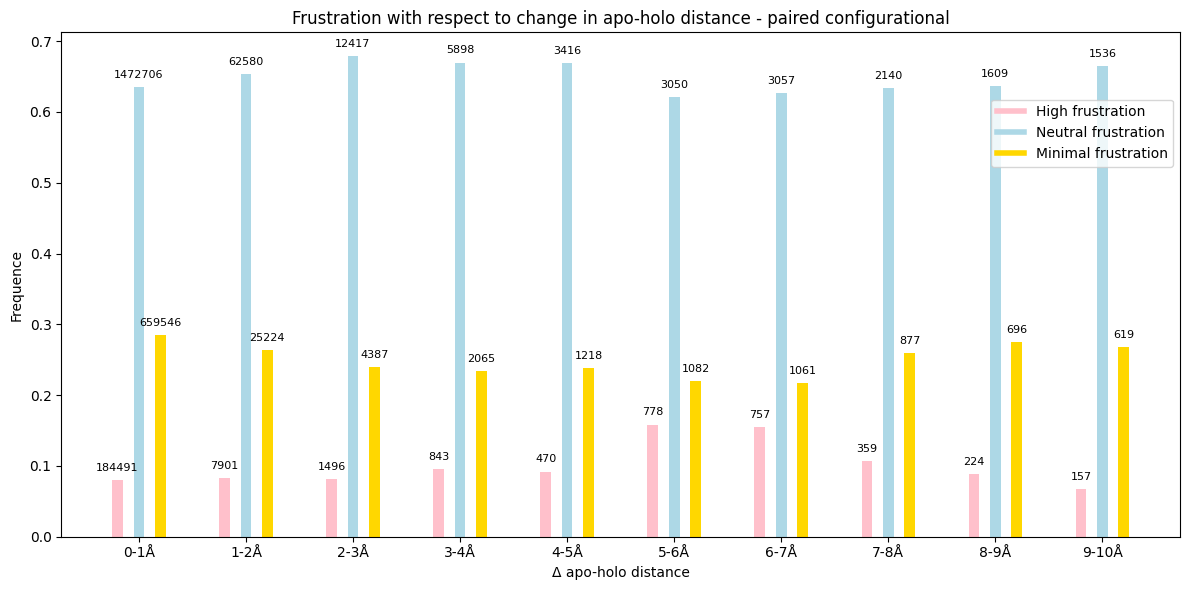

In [ ]:
   
cryptobench_frustration, cryptobench_distances = load_paired_dataset_with_distance('cryptobench-dataset', 'configurational')
assert len(cryptobench_frustration) == len(cryptobench_distances)
cryptobench_distances = clip_distances(cryptobench_distances)

rigid_frustration, rigid_distances = load_paired_dataset_with_distance('rigid-dataset', 'configurational')
assert len(rigid_frustration) == len(rigid_distances)
rigid_distances = clip_distances(rigid_distances)

frustration = np.concatenate((cryptobench_frustration, rigid_frustration), axis=0)
rounded_distances = np.concatenate((cryptobench_distances, rigid_distances), axis=0)

barplot_paired_frustration_frequence(frustration, rounded_distances, 
                              title='Frustration with respect to change in apo-holo distance - paired configurational', 
                              labels=['High frustration', 'Neutral frustration', 'Minimal frustration'],
                              xlabel='Δ apo-holo distance')

### Conlusion
There is a noticeable spike in the frequency of **high frustration** for **x = 4** and **x = 5**. Otherwise, the bar distribution appears similar across the different x-values.

## Technical remark: AUTH vs. SEQ labeling
Our binding annotation (which uses auth_seq_ids) matches with the labeling of frustration tools (which also uses auth_seq_ids) - check '1ad1' for example. 